In [1]:
import pandas as pd
import geopandas as gpd

/home/simonhans/anaconda3/envs/GrapeExpectations/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
gdb_path = '../data/soil/extract/gSSURGO_WA.gdb'

vine_path = '../data/polygons/RegressionRidge.geojson'
vine_poly = gpd.read_file(vine_path)

vine_smol_path = '../data/polygons/RegressionRidge_smol_smol.pkl'
vine_smol_poly = pd.read_pickle(vine_smol_path)

In [3]:
vine_poly = vine_poly.to_crs('EPSG:5070')
vine_smol_poly = vine_smol_poly.to_crs('EPSG:5070')

bbox = tuple(vine_poly.total_bounds)

soils_subset = gpd.read_file(
    gdb_path,
    layer='MUPOLYGON',
    bbox=bbox
)

soils_clipped = gpd.clip(soils_subset, vine_poly)
# soils_clipped.to_file('soils_vineyard.gpkg', driver='GPKG')

In [4]:
soil_exploded = soils_clipped.explode(index_parts=False)

In [5]:
soil_clipped_to_vine = gpd.clip(soil_exploded, vine_poly)

In [6]:
soil_clipped_to_plot = gpd.clip(soil_exploded, vine_smol_poly)

In [7]:
soil_final = soils_clipped.dissolve(by='MUKEY', as_index=False)

In [8]:
import matplotlib.pyplot as plt

In [9]:
target_crs = 'EPSG:32610'

vine_smol_poly = vine_smol_poly.to_crs(target_crs)
soil_proj = soil_clipped_to_plot.to_crs(target_crs)


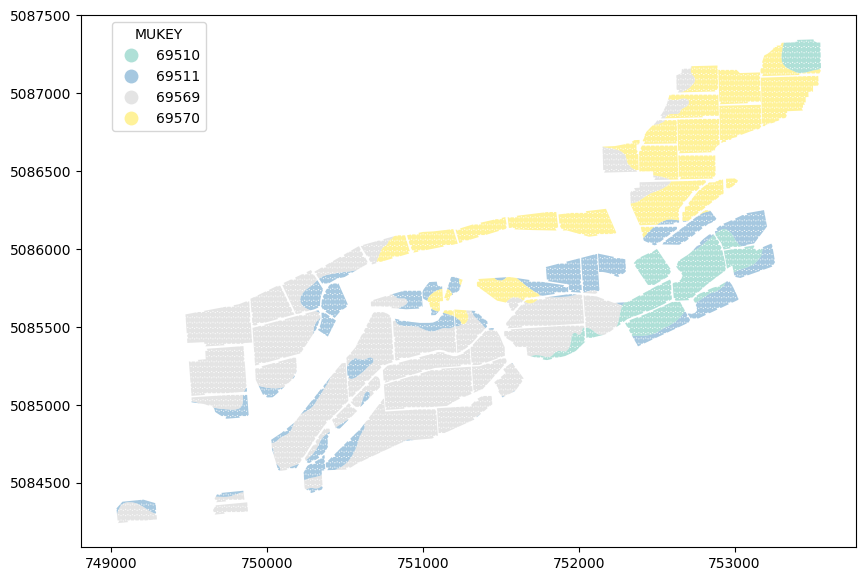

In [10]:

fig, ax = plt.subplots(figsize=(10, 10))

# Plot soil polygons colored by MUKEY
soil_proj.plot(
    ax=ax, 
    column='MUKEY',
    cmap='Set3',
    edgecolor='black',
    alpha=0.7,
    linewidth=0,
    legend=True,
    legend_kwds={'title': 'MUKEY'}
)

# Plot vineyard outline on top
vine_smol_poly.plot(
    ax=ax,
    color='none',
    edgecolor='red',
    linewidth=0
)

# Grab the legend object and set its location
leg = ax.get_legend()
if leg:
    leg.set_bbox_to_anchor((0.17, 1))  # move it outside top-right corner
    # or use standard locations like 'upper left', 'lower right', etc.
    # leg.set_loc('upper left')  # only works in newer Matplotlib

plt.show()


In [11]:
import fiona
import pandas as pd
pd.set_option('display.max_columns', None)
def read_table_subset(gdb_path, layer_name, filter_keys = None, key_column = None):
    '''
    Read a non-spatial layer from a .gdb into a Pandas DataFrame,
    optionally keeping only rows where key_column is in filter_keys.
    '''
    with fiona.open(gdb_path, layer = layer_name) as src:
        if filter_keys is None:
            df = pd.DataFrame([f['properties'] for f in src])
        else:
            # Only include rows where key_column is in filter_keys
            records = [f['properties'] for f in src if f['properties'][key_column] in filter_keys]
            df = pd.DataFrame(records)
    return df

In [12]:
vineyard_mukeys = soils_clipped['MUKEY'].unique()

components_vineyard = read_table_subset(
    gdb_path,
    'component',
    filter_keys = vineyard_mukeys,
    key_column = 'mukey'
)

In [13]:
cokeys = components_vineyard['cokey'].unique()

horizons_vineyard = read_table_subset(
    gdb_path,
    'chorizon',
    filter_keys = cokeys,
    key_column = 'cokey'
)

In [14]:
chkeys = horizons_vineyard['chkey'].unique()

textures_vineyard = read_table_subset(
    gdb_path,
    'chtexturegrp',
    filter_keys = chkeys,
    key_column = 'chkey'
)

In [15]:
# Merge horizons → textures
horizons_vineyard = horizons_vineyard.merge(
    textures_vineyard,
    on="chkey",
    how="left",
    suffixes=("", "_tex")
)

# Merge horizons → component
horizons_vineyard = horizons_vineyard.merge(
    components_vineyard,
    on="cokey",
    how="left",
    suffixes=("", "_comp")
)

In [16]:
non_cols = [col for col in horizons_vineyard.columns if horizons_vineyard[col].unique().any() == None]

horizons_vineyard = horizons_vineyard.drop(columns = non_cols)

# drop the non-dominant soil layer
horizons_vineyard = horizons_vineyard.drop(horizons_vineyard[horizons_vineyard['mukey'] == '69508'].index)

# drop the unweathered bedrock outcrop
horizons_vineyard = horizons_vineyard.drop(horizons_vineyard[horizons_vineyard['cokey'] == '25272336'].index)
horizons_vineyard = horizons_vineyard.drop(horizons_vineyard[
    horizons_vineyard['texdesc'].str.contains('bedrock', case=False, na=False)
].index)



In [17]:
single_value_cols = horizons_vineyard.columns[horizons_vineyard.nunique() == 1].tolist()

horizons_vineyard = horizons_vineyard.drop(columns = single_value_cols)

# Drop columns not needed for numeric analysis
cols_to_drop = ['chtgkey', 'rvindicator', 'texdesc', 'texture']
horizons_vineyard = horizons_vineyard.drop(columns=cols_to_drop)

# Drop duplicate horizons (same component and depth)
# horizons_numeric = horizons_numeric.drop_duplicates(subset=['cokey', 'hzdept_h', 'hzdepb_h'])


In [25]:
horizons_vineyard = horizons_vineyard.drop_duplicates()

In [26]:
horizons_vineyard = horizons_vineyard.drop(horizons_vineyard[horizons_vineyard['hzname'] == 'H3'].index)

In [27]:
horizons_vineyard = horizons_vineyard.reset_index(drop = True)

In [28]:
horizons_vineyard

,awc_h,awc_l,awc_r,caco3_h,caco3_r,cec7_h,cec7_l,cec7_r,chkey,claytotal_h,claytotal_l,claytotal_r,cokey,dbovendry_r,dbthirdbar_h,dbthirdbar_l,dbthirdbar_r,desgnvert,ec_h,ec_r,frag3to10_h,frag3to10_r,fraggt10_h,fraggt10_r,hzdepb_r,hzdept_r,hzname,kffact,kwfact,om_h,om_l,om_r,ph1to1h2o_h,ph1to1h2o_l,ph1to1h2o_r,sandco_r,sandfine_r,sandmed_r,sandtotal_r,sandvc_r,sandvf_r,sieveno10_h,sieveno10_l,sieveno10_r,sieveno200_h,sieveno200_l,sieveno200_r,sieveno40_h,sieveno40_l,sieveno40_r,sieveno4_h,sieveno4_l,sieveno4_r,silttotal_r,wfifteenbar_r,wsatiated_r,wtenthbar_r,wthirdbar_r,airtempa_l,airtempa_r,compname,comppct_r,corsteel,elev_h,elev_l,elev_r,ffd_h,ffd_l,ffd_r,map_h,map_l,map_r,mukey,nirrcapcl,nirrcapscl,otherph,rsprod_h,rsprod_l,rsprod_r,taxclname,taxgrtgroup,taxpartsize,taxsubgrp,taxsuborder,tfact
0,0.10,0.07,0.09,0.0,0.0,6.0,1.0,3.5,75396118,5.0,0.0,2.5,25272334,1.41,1.45,1.25,1.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0,H1,.24,.24,1.0,0.5,0.75,7.4,6.6,7.0,2.0,40.000000,13.1,80.699997,0.0,25.600000,100.0,100.0,100.0,40.0,30.0,35.0,90.0,80.0,85.0,100.0,100.0,100.0,16.799999,2.4,46.0,16.100000,10.2,12.0,12.0,Burbank,100,Low,240.0,60.0,150.0,190.0,190.0,190.0,228.0,152.0,190.0,69510,7,s,NIRR,NaN,NaN,NaN,"Sandy-skeletal, mixed, mesic Xeric Torriorthents",Torriorthents,sandy-skeletal,Xeric Torriorthents,Orthents,2.0
1,0.09,0.06,0.08,0.0,0.0,6.0,1.0,3.5,75396119,5.0,0.0,2.5,25272334,1.52,1.55,1.35,1.45,2.0,0.0,0.0,0.0,0.0,0.0,0.0,43,10,H2,.24,.24,0.5,0.0,0.25,7.4,6.6,7.0,13.0,27.600000,21.1,81.099998,3.8,15.600000,100.0,75.0,87.5,30.0,15.0,22.5,60.0,40.0,50.0,100.0,100.0,100.0,16.400000,1.7,37.0,13.900000,8.4,12.0,12.0,Burbank,100,Low,240.0,60.0,150.0,190.0,190.0,190.0,228.0,152.0,190.0,69510,7,s,NIRR,NaN,NaN,NaN,"Sandy-skeletal, mixed, mesic Xeric Torriorthents",Torriorthents,sandy-skeletal,Xeric Torriorthents,Orthents,2.0
2,0.10,0.07,0.09,0.0,0.0,6.0,1.0,3.5,75396122,5.0,0.0,2.5,25272335,1.41,1.45,1.25,1.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0,H1,.24,.24,1.0,0.5,0.75,7.4,6.6,7.0,2.0,40.000000,13.1,80.699997,0.0,25.600000,100.0,100.0,100.0,40.0,30.0,35.0,90.0,80.0,85.0,100.0,100.0,100.0,16.799999,2.4,46.0,16.100000,10.2,12.0,12.0,Burbank,50,Low,240.0,60.0,150.0,190.0,190.0,190.0,228.0,152.0,190.0,69511,7,s,NIRR,NaN,NaN,NaN,"Sandy-skeletal, mixed, mesic Xeric Torriorthents",Torriorthents,sandy-skeletal,Xeric Torriorthents,Orthents,2.0
3,0.09,0.06,0.08,0.0,0.0,6.0,1.0,3.5,75396123,5.0,0.0,2.5,25272335,1.52,1.55,1.35,1.45,2.0,0.0,0.0,0.0,0.0,0.0,0.0,43,10,H2,.24,.24,0.5,0.0,0.25,7.4,6.6,7.0,13.0,27.600000,21.1,81.099998,3.8,15.600000,100.0,75.0,87.5,30.0,15.0,22.5,60.0,40.0,50.0,100.0,100.0,100.0,16.400000,1.7,37.0,13.900000,8.4,12.0,12.0,Burbank,50,Low,240.0,60.0,150.0,190.0,190.0,190.0,228.0,152.0,190.0,69511,7,s,NIRR,NaN,NaN,NaN,"Sandy-skeletal, mixed, mesic Xeric Torriorthents",Torriorthents,sandy-skeletal,Xeric Torriorthents,Orthents,2.0
4,0.12,0.09,0.11,0.0,0.0,7.0,2.0,4.5,75396302,6.0,1.0,3.5,25272397,1.62,1.65,1.45,1.55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0,H1,.15,.15,1.0,0.5,0.75,8.4,7.4,7.9,12.8,27.500000,21.0,80.400002,3.6,15.500000,100.0,100.0,100.0,30.0,15.0,22.5,100.0,65.0,82.5,100.0,100.0,100.0,16.100000,3.3,39.0,17.799999,11.9,8.0,10.0,Quincy,90,Moderate,1372.0,61.0,717.0,200.0,100.0,150.0,305.0,152.0,229.0,69569,4,e,"NIRR, WARM",800.0,500.0,600.0,"Mixed, mesic Xeric Torripsamments",Torripsamments,not used,Xeric Torripsamments,Psamments,5.0
5,0.12,0.08,0.10,3.0,2.0,6.0,1.0,3.5,75396303,7.0,1.0,4.0,25272397,1.67,1.70,1.50,1.60,2.0,2.0,1.0,0.0,0.0,0.0,0.0,152,23,H2,.32,.32,0.5,0.0,0.25,8.4,7.4,7.9,1.9,39.400002,12.9,79.400002,0.0,25.200001,100.0,100.0,100.0,30.0,10.0,20.0,80.0,65.0,72.5,100.0,100.0,100.0,16.600000,3.0,37.0,17.200001,11.3,8.0,10.0,Quincy,90,Moderate,1372.0,61.0,717.0,200.0,100.0,150.0,305.0,152.0,229.0,69569,4,e,"NIRR, WARM",800.0,500.0,600.0,"Mixed, mesic Xeric Torripsamments",Torripsamments,not used,Xeric Torripsamments,Psamments,5.0
6,0.09,0.08,0.09,0.0,0.0,5.0,0.0,2.5,75396304,5.0,0.0,2.5,25272398,1.62,1.70,1.40,1.55

In [29]:
import numpy as np
def summarize_horizons(df):
    df = df.copy()

    # --- Compute horizon thickness ---
    df['thickness'] = df['hzdepb_r'] - df['hzdept_r']

    # --- Force numeric columns (convert bad strings to NaN) ---
    numeric_cols = [
        'sandtotal_r', 'silttotal_r', 'claytotal_r',
        'ph1to1h2o_r', 'cec7_r', 'om_r',
        'caco3_r', 'dbovendry_r', 'kffact', 'kwfact',
        'frag3to10_r', 'fraggt10_r',
        'awc_r', 'ec_r',
        'wthirdbar_r', 'wtenthbar_r', 'wfifteenbar_r',
        'wsatiated_r'
    ]
    for col in numeric_cols + ['hzdept_r', 'hzdepb_r', 'thickness']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # --- Define weighted mean function (safe) ---
    def weighted_mean(x):
        w = df.loc[x.index, 'thickness']
        valid = x.notna() & w.notna() & (w > 0)
        if valid.sum() == 0:
            return np.nan
        return np.average(x[valid], weights=w[valid])

    # --- Summarize by map unit ---
    summary = df.groupby('mukey').agg({
        # --- Texture & composition ---
        'sandtotal_r': weighted_mean,
        'silttotal_r': weighted_mean,
        'claytotal_r': weighted_mean,
        'frag3to10_r': weighted_mean,
        'fraggt10_r': weighted_mean,
        'awc_r': weighted_mean,
        'cec7_r': weighted_mean,
        'om_r': weighted_mean,
        'caco3_r': weighted_mean,

        # --- Soil physics ---
        'dbovendry_r': weighted_mean,
        'wthirdbar_r': weighted_mean,
        'wtenthbar_r': weighted_mean,
        'wfifteenbar_r': weighted_mean,
        'wsatiated_r': weighted_mean,

        # --- Chemistry ---
        'ph1to1h2o_r': weighted_mean,
        'ec_r': weighted_mean,

        # --- Erosion & permeability factors ---
        'kffact': 'mean',
        'kwfact': 'mean',

        # --- Depth ---
        'thickness': 'sum',    # total profile depth
        'hzdepb_r': 'max'      # deepest horizon boundary
    }).reset_index()

    # --- Rename ---
    summary.rename(columns={
        'thickness': 'profile_depth',
        'hzdepb_r': 'max_depth'
    }, inplace=True)

    return summary


In [30]:
hv = summarize_horizons(horizons_vineyard)

In [31]:
hv

,mukey,sandtotal_r,silttotal_r,claytotal_r,frag3to10_r,fraggt10_r,awc_r,cec7_r,om_r,caco3_r,dbovendry_r,wthirdbar_r,wtenthbar_r,wfifteenbar_r,wsatiated_r,ph1to1h2o_r,ec_r,kffact,kwfact,profile_depth,max_depth
0,69510,81.006975,16.493023,2.500000,0.0,0.0,0.082326,3.500000,0.366279,0.000000,1.494419,8.818604,14.411628,1.862791,39.093023,7.0,0.000000,0.240,0.240,43,43
1,69511,81.006975,16.493023,2.500000,0.0,0.0,0.082326,3.500000,0.366279,0.000000,1.494419,8.818604,14.411628,1.862791,39.093023,7.0,0.000000,0.240,0.240,43,43
2,69569,79.551317,16.524342,3.924342,0.0,0.0,0.101513,3.651316,0.325658,1.697368,1.662434,11.390790,17.290790,3.045395,37.302632,7.9,0.848684,0.235,0.235,152,152
3,69570,80.699997,16.799999,2.500000,0.0,0.0,0.090000,2.500000,0.400000,0.000000,1.620000,9.700000,15.500000,2.100000,38.000000,7.9,0.000000,0.240,0.240,76,76


In [32]:
target_crs = 'EPSG:5070'

vine_smol_poly = vine_smol_poly.to_crs(target_crs)
soil_proj = soil_clipped_to_plot.to_crs(target_crs)


In [33]:
df = pd.merge(hv, soil_proj, how = 'inner', left_on = 'mukey', right_on = 'MUKEY')

In [34]:
vine_smol_poly['plot_id'] = vine_smol_poly.index

In [35]:
# Intersect polygons — this can be slow for large datasets, but precise
overlaps = gpd.overlay(vine_smol_poly, soil_proj, how='intersection')

# Compute intersection area in consistent units (e.g., m²)
overlaps['area_overlap'] = overlaps.geometry.area

# Compute area fractions relative to each plot
plot_areas = vine_smol_poly[['plot_id', 'geometry']].copy()
plot_areas['plot_area'] = plot_areas.geometry.area

# Merge areas back to overlaps
overlaps = overlaps.merge(plot_areas[['plot_id', 'plot_area']], on='plot_id')
overlaps['area_fraction'] = overlaps['area_overlap'] / overlaps['plot_area']


/home/simonhans/anaconda3/envs/GrapeExpectations/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 107 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  


In [36]:
overlaps = overlaps.merge(
    hv[[
        'sandtotal_r', 'silttotal_r', 'claytotal_r', 
        'awc_r', 'cec7_r', 'om_r', 
        'ph1to1h2o_r', 'ec_r',
        'profile_depth', 'max_depth','mukey',
        'frag3to10_r', 'fraggt10_r', 'dbovendry_r', 'caco3_r'
    ]],
    right_on='mukey',
    left_on = 'MUKEY',
    how='left'
)


In [38]:
def area_weighted_mean(x, weights):
    valid = x.notna() & weights.notna()
    if valid.sum() == 0:
        return np.nan
    return np.average(x[valid], weights=weights[valid])

weighted_cols = ['sandtotal_r', 'silttotal_r', 'claytotal_r', 
        'awc_r', 'cec7_r', 'om_r', 
        'ph1to1h2o_r', 'ec_r',
        'profile_depth', 'max_depth',
        'frag3to10_r', 'fraggt10_r', 'dbovendry_r', 'caco3_r']

plot_soil_summary = (
    overlaps.groupby('plot_id')
    .apply(lambda g: pd.Series({
        col: area_weighted_mean(g[col], g['area_fraction'])
        for col in weighted_cols
    }))
    .reset_index()
)


In [39]:
plot_soil_summary = pd.DataFrame(plot_soil_summary)

In [41]:
plot_soil_summary

,plot_id,sandtotal_r,silttotal_r,claytotal_r,awc_r,cec7_r,om_r,ph1to1h2o_r,ec_r,profile_depth,max_depth,frag3to10_r,fraggt10_r,dbovendry_r,caco3_r
0,0,81.006975,16.493023,2.500000,0.082326,3.500000,0.366279,7.0,0.000000,43.0,43.0,0.0,0.0,1.494419,0.000000
1,1,81.006975,16.493023,2.500000,0.082326,3.500000,0.366279,7.0,0.000000,43.0,43.0,0.0,0.0,1.494419,0.000000
2,2,81.006975,16.493023,2.500000,0.082326,3.500000,0.366279,7.0,0.000000,43.0,43.0,0.0,0.0,1.494419,0.000000
3,3,81.006975,16.493023,2.500000,0.082326,3.500000,0.366279,7.0,0.000000,43.0,43.0,0.0,0.0,1.494419,0.000000
4,4,81.006975,16.493023,2.500000,0.082326,3.500000,0.366279,7.0,0.000000,43.0,43.0,0.0,0.0,1.494419,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,3593,79.551317,16.524342,3.924342,0.101513,3.651316,0.325658,7.9,0.848684,152.0,152.0,0.0,0.0,1.662434,1.697368
3594,3594,79.551317,16.524342,3.924342,0.101513,3.651316,0.325658,7.9,0.848684,152.0,152.0,0.0,0.0,1.662434,1.697368
3595,3595,79.551317,16.524342,3.924342,0.101513,3.651316,0.325658,7.9,0.848684,152.0,152.0,0.0,0.0,1.662434,1.697368
3596,3596,79.551317,16.524342,3.924342,0.101513,3.651316,0.325658,7.9,0.848684,152.0,152.0,0.0,0.0,1.662434,1.697368


In [40]:
plot_soil_summary.to_pickle('../data/soil/plot_summary.pkl')